<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [1]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [16]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('data/fea_sample/storage_sample_stage4_4.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage4_4.h5', 'test_df',mode='r')

In [25]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [26]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# Feature Engineering: Preferential Attachment

In [108]:
df_final_train['preferential_followers'] = df_final_train.num_followers_s * df_final_train.num_followers_d
df_final_test['preferential_followers'] = df_final_test.num_followers_s * df_final_test.num_followers_d

<b> Observation(s) </b>
<p> Preferential attachment describes the "richness" of two nodes in the social network.</p>
<p> A node may be considered "rich", as the node with many friends tends to have more connections in the social graph </p>
<p> This feature somehow quantifies the attachment of source node over the destination based on the number of followers. Greater the number of connections/ followers for <b> both </b> source and destination node, greater the value of preferential attachment </p>

# Feature Engineering:SVD Dot products

In [109]:
df_final_train['svd_dot_U'] = df_final_train.svd_u_s_1*df_final_train.svd_u_d_1 + \
df_final_train.svd_u_s_2*df_final_train.svd_u_d_2 + df_final_train.svd_u_s_3*df_final_train.svd_u_d_3 + \
df_final_train.svd_u_s_4*df_final_train.svd_u_d_4 + df_final_train.svd_u_s_5*df_final_train.svd_u_d_5 + \
df_final_train.svd_u_s_6*df_final_train.svd_u_d_6


In [110]:
df_final_train['svd_dot_V'] = df_final_train.svd_v_s_1*df_final_train.svd_v_d_1 + \
df_final_train.svd_v_s_2*df_final_train.svd_v_d_2 + df_final_train.svd_v_s_3*df_final_train.svd_v_d_3 + \
df_final_train.svd_v_s_4*df_final_train.svd_v_d_4 + df_final_train.svd_v_s_5*df_final_train.svd_v_d_5 + \
df_final_train.svd_v_s_6*df_final_train.svd_v_d_6


In [111]:
df_final_test['svd_dot_U'] = df_final_test.svd_u_s_1*df_final_test.svd_u_d_1 + \
df_final_test.svd_u_s_2*df_final_test.svd_u_d_2 + df_final_test.svd_u_s_3*df_final_test.svd_u_d_3 + \
df_final_test.svd_u_s_4*df_final_test.svd_u_d_4 + df_final_test.svd_u_s_5*df_final_test.svd_u_d_5 + \
df_final_test.svd_u_s_6*df_final_test.svd_u_d_6


In [112]:
df_final_test['svd_dot_V'] = df_final_test.svd_v_s_1*df_final_test.svd_v_d_1 + \
df_final_test.svd_v_s_2*df_final_test.svd_v_d_2 + df_final_test.svd_v_s_3*df_final_test.svd_v_d_3 + \
df_final_test.svd_v_s_4*df_final_test.svd_v_d_4 + df_final_test.svd_v_s_5*df_final_test.svd_v_d_5 + \
df_final_test.svd_v_s_6*df_final_test.svd_v_d_6


<b> Observation(s) </b>
<p>SVD features were dervied from the adjacency matrix of multple users in the social network indicating the presence of directed edge connection from one user_i to user_j. The adjaceny matrix due to its sparsity and large size, we are converting the information of edge connections in a lower dimensional vectors </p>
<p>The dot product of U and V vectors can indicate the strength of similarity based on the adjacency matrix and it also helps explain the variance observed by each user</p>
<p> The magnitude of the dot product can be indirectly interpreted to indicate the similarity between source and destination nodes </p>
<p> For example, in dot product we are doing component multiplication of the source and destination node and summing up to a scaler value. Naturally, SVD-Dot will be high when<b> both</b> magnitude of source and destination 6 dim vectors are high.
Even if one of them is low, SVD_dot decreases. </p>
<p> If SVD-Dot is high for a pair of (user_i,user_j), it could indicate that user_i is also within the same community of user_j, or u_i follows u_j, as well as user_j follows back user_i or within the same community, indicating high symmetric similarity </p>

In [113]:
df_final_train.head()

,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,num_followers_d,...,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,svd_dot_U,svd_dot_V,preferential_followers,preferential_followees
0,0,0.000000,0.000000,0.000000,11,15,8,0,0,6,...,1.355369e-12,-4.675320e-13,1.128586e-06,-6.616718e-14,9.771080e-13,4.160006e-14,1.114951e-11,2.238777e-12,66,120
1,0,0.187135,0.028382,0.343828,17,61,142,11,32,94,...,-1.245166e-12,1.636951e-10,-3.112900e-10,-6.738902e-02,2.607853e-11,2.372904e-09,3.192812e-03,9.068719e-04,1598,8662
2,0,0.369565,0.156957,0.566038,35,41,22,26,17,28,...,-1.857826e-17,-1.095444e-17,1.710528e-18,1.765531e-17,-1.232102e-18,-7.872742e-18,7.156726e-33,1.028763e-33,980,902
3,0,0.000000,0.000000,0.000000,2,5,7,0,0,11,...,9.818087e-10,-3.454680e-11,5.214019e-08,-9.595841e-13,3.047045e-10,1.246592e-13,4.710691e-20,3.159735e-18,22,35
4,0,0.000000,0.000000,0.000000,5,11,3,0,0,1,...,3.453540e-15,-1.121311e-15,3.097681e-09,-8.173307e-16,1.122949e-15,5.094874e-17,7.775088e-14,3.708786e-16,5,33


## Hyperparameter Tuning: XGboost (max_depth and n_estimators)

In [119]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
X_train = df_final_train
X_test = df_final_test

In [51]:
# Reference https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
#To balance the class weight, sample_pos_weight = #-ve pts/#+ve pts
from collections import Counter 
counter = Counter(y_train)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 0.998


In [129]:
from sklearn.model_selection import RandomizedSearchCV
params ={'max_depth':range(1,20,3),'n_estimators':[10,25,50,100,150,200]}
model = xgb.XGBClassifier(verbose=1,n_jobs=-1)
clf = RandomizedSearchCV(model,params,cv=5,scoring='f1',return_train_score=True,n_jobs=-1,verbose=3,n_iter=5)
result=clf.fit(X_train,y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 18.5min finished


[17:48:27] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [130]:
result.best_params_

{'n_estimators': 100, 'max_depth': 19}

In [131]:
result.best_score_

0.9795460362276346

<b> Observation(s) </b>
<p> In boosting, the intuition is to have low variance, high bias models as our base learners and with the power of addtive combining, the overall bias can be reduced without affecting the variance</p>
<p> Naturally, we want our base trees to have as shallow depth as possible in order to have the least variance. Due to this,
    the max_depth parameter has the maximum impact on the performance, and the tuning range is kept small. </p>
<p>Each base model is trained to fit the residual error of its previous model, and progressivly the training error reduces for each model. So greater the number of n_estimators, lower will be the training error </p> 

# Tuning  subsample, colsample_bytree

In [155]:
#Reference: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
best_n_estimators = 100
best_max_depth = 19
model = xgb.XGBClassifier(n_jobs=-1,n_estimators=best_n_estimators,max_depth=best_max_depth)
params_test2 =  {
'subsample':[i/10.0 for i in range(6,10)],
'colsample_bytree':[i/10.0 for i in range(6,10)],
} 
clf = RandomizedSearchCV(model,params_test2,cv=5,scoring='f1',return_train_score=True,n_jobs=-1,verbose=3,n_iter=5)

result2=clf.fit(X_train,y_train)

results2 = pd.DataFrame.from_dict(clf.cv_results_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 18.5min finished


In [156]:
result2.best_params_

{'subsample': 0.6, 'colsample_bytree': 0.8}

In [157]:
result2.best_score_

0.9807360915998163

<b> Observation(s) </b>
<p> Subsample hyperparameter refers to the ratio of the number of data points to be sampled into each tree <p>
<p> Before growing the trees, if only a fraction of points are used for sampling, it could prevent overfitting, and increase bias. Equivalent to  Row sampling in Random Forest, as the subsample value decreases, only a few points will be sampled for each individual tree. This results in each individual data set for training trees to be very different from other sets. Results in low variance </p> 
<p> colsample by tree indirectly refers to the concept of column sampling without replacement in random forest.Lesser the value, lesser the fraction number of features will be sampled into each individual tree. It avoids extreme overfitting by base models, as each model only gets to see a subset of features. Each base model is trained on a different aspect of the population data set, results in better variance </p>

# Fitting the best model with the tuned hyper parameters

In [158]:
best_n_estimators = 100
best_max_depth = 19
best_subsample=0.6
best_colsample_bytree=0.8
best_model = xgb.XGBClassifier(n_jobs=-1,n_estimators=best_n_estimators,max_depth=best_max_depth,learning_rate=0.1,\
                              subsample=best_subsample,colsample_bytree=best_colsample_bytree)
best_model.fit(X_train,y_train)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=19,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.6,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [159]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

In [162]:
from sklearn.metrics import f1_score
print('Train f1 score',round(f1_score(y_train,y_train_pred)*100),2)
print('Test f1 score',f1_score(y_test,y_test_pred)*100)

Train f1 score 99.9910096197069
Test f1 score 93.02846990143408


<b> Observation(s) </b>
<p> The train score moderately differs from the test score, indicating the chances of overfitting. High train score could be due to huge number of base models learning on the residuals of its previous stages. </p>
<p> High test f1 score could indicate that both precision AND recall on the test set seems to be high. Higher recall means less FALSE NEGATIVES and higher precision means less FALSE POSITIVES </p>

# Representation of results

In [164]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


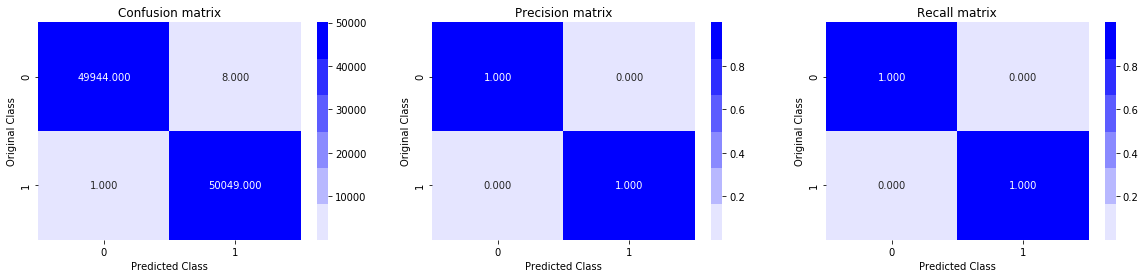

In [167]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)


<b> Obervation(s) </b>
<p> Every point is being classified correctly indicating perfect precision and recall on train data </p>
<p> Defenitely the new engineered features like prefrential attachment and svd dots seems to have reduced the missclassification rate </p>

Test confusion_matrix


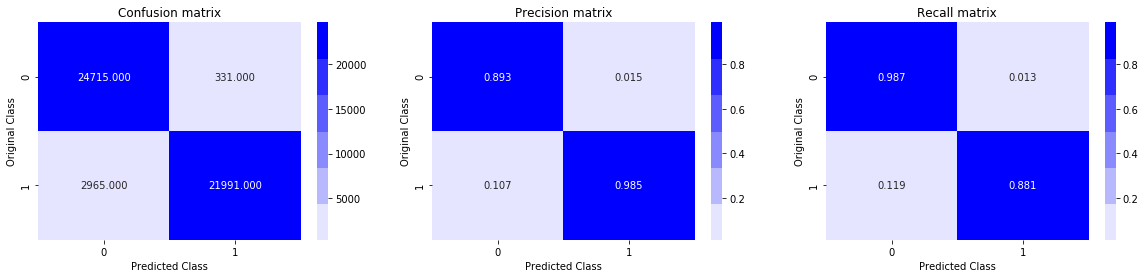

In [166]:
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

<b> Observation(s) </b>
<p> The reason why the same precision fo class 0 is not maintained in test also could be due to cold start problem.(i.e the presence of data points present in test but not in test) and the lack of information of absence of nodes. The '0' class labels were manually designed </p>
<p> Recall for class 1 also seems to have been affected </p>

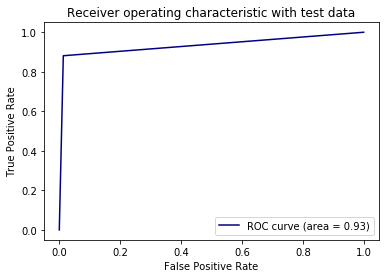

In [168]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

<b> Observation(s) </b>
<p> The ROC curve follows the ideal roc curve indicating good classifying power. 93% chance for the model to classify positive and negative class </p>


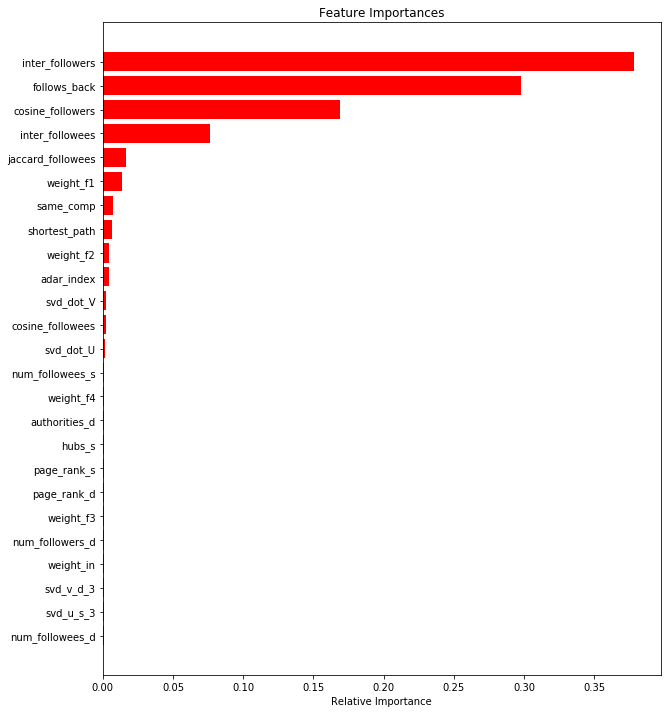

In [170]:
features = df_final_train.columns
importances = best_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<b> Observation(s) </b>
<p> While designing the new features, still the intersection of followers between source and destination nodes seems to have highest importance. </p>
<p> The SVD-DOT U and V features seems to better explaining than the individual U and V singular vectors </p>
<p> The magnitude of the dot product can be indirectly interpreted to indicate the similarity between source and destination nodes </p>
<p> If SVD-Dot is high for a pair of (user_i,user_j), it could indicate that user_i is also within the same community of user_j, or u_i follows u_j, as well as user_j follows back user_i or within the same community, indicating high symmetric similarity </p>

# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.